In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

data_path = '../raw_data/100k_data.csv'
df_all = pd.read_csv(data_path)
df_all = df_all.dropna()
df_sample = df_all.dropna().sample(10000,random_state=0)

def binary_cat_upvotes(original_df, threshold=30):
    """
    Takes column from df called 'upvotes' and returns df with new column
    'cat_upvotes' which is 1 if upvotes is above threshold, and 0 otherwise.
    """
    df = original_df.copy()
    if 'upvotes' not in original_df.columns:
        raise ValueError("df has no column named 'upvotes'")
    def trans(number):
        if number >= threshold:
            return 1
        else:
            return 0
    df['cat_upvotes'] = df['upvotes'].apply(trans)
    return df

def multi_cat_upvotes(original_df, int_list=[10,100,1000]):
    """
    Takes column from df and returns df with new
    column 'cat_upvotes' based on list passed as an argument
    """
    df = original_df.copy()
    def trans(number):
        for index, integer in enumerate(int_list):
            if number < integer:
                return index
        return len(int_list)
    df['cat_upvotes'] = df['upvotes'].apply(trans)
    return df

def basic(original_df,keep_timestamp=False):
    """
    Transforms 'time_stamp' column from df into individual components 'year',
    'month','day','weekday','hour','minute'
    """
    df = original_df.copy()

    if 'time_stamp' not in df.columns:
        raise ValueError("df has no column named 'time_stamp'")
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='s')

    df['year'] = df.time_stamp.dt.year
    df['month'] = df.time_stamp.dt.month
    df['day'] = df.time_stamp.dt.day
    df['weekday'] = df.time_stamp.dt.weekday
    df['hour'] = df.time_stamp.dt.hour
    df['minute'] = df.time_stamp.dt.minute

    if keep_timestamp is False:
        df = df.drop(columns='time_stamp')
    return df

def cyclize(original_df):
    """
    Transforms columns named 'month','day','hour','minute' into sin and cos
    cyclic values for use with machine learning models
    """
    df = original_df.copy()

    need_list = ['month','day','hour','minute']
    max_dict = {
        'month':12,
        'day': 31,
        'hour': 23,
        'minute': 59
    }

    for column in need_list:
        if column in df.columns:
            def sin_trans(number):
                return math.sin(number * (2. * math.pi / max_dict[column]))
            def cos_trans(number):
                return math.cos(number * (2. * math.pi / max_dict[column]))
            df['sin_' + column] = df[column].apply(sin_trans)
            df['cos_' + column] = df[column].apply(cos_trans)
            df = df.drop(columns=column, axis=1)

    return df

def encode_weekday(original_df, keep_weekday_column=False):
    """
    OneHotEncodes column from df column named 'weekday'
    """
    df = original_df.copy()

    enc = OneHotEncoder(handle_unknown='ignore')
    df_wkdy = pd.DataFrame(enc.fit_transform(df[['weekday']]).toarray())
    df = pd.concat([df.reset_index(), df_wkdy], axis=1)
    df = df.set_index('index')
    if keep_weekday_column==False:
        df = df.drop('weekday', axis=1)
    return df

def transform_timestamp(original_df):
    """
    Takes 'time_stamp' column from df and returns df preprocessed and
    ready for machine learning
    """
    df = original_df.copy()
    df = basic(df)
    df = cyclize(df)
    df = encode_weekday(df)
    if 'year' in df.columns:
        scaler = MinMaxScaler()
        df['year'] = scaler.fit_transform(df[['year']].copy())
    return df

''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

df = df_all[['time_stamp','upvotes']]
df = transform_timestamp(df)
df = binary_cat_upvotes(df, threshold=30)
df = df.drop(columns='upvotes')

df

2022-11-23 20:02:10.742195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,year,sin_month,cos_month,sin_day,cos_day,sin_hour,cos_hour,sin_minute,cos_minute,0,1,2,3,4,5,6,cat_upvotes
index,,,,,,,,,,,,,,,,,
0,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,-0.940700,-0.339239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,-0.638244,-0.769834,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,-0.461093,-0.887352,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,0.263103,-0.964768,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,0.364161,-0.931336,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99260,0.0,0.5,-0.866025,-0.848644,0.528964,-0.519584,0.854419,0.874763,0.484551,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
99262,0.0,0.5,-0.866025,-0.848644,0.528964,-0.730836,0.682553,0.638244,-0.769834,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
99263,0.0,0.5,-0.866025,-0.848644,0.528964,-0.730836,0.682553,0.999646,-0.026621,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [2]:
X = df.drop(columns='cat_upvotes')
y = df['cat_upvotes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

# How many upvoted samples do I have in each split?
train_upvoted = np.sum(y_train[y_train == 1])
val_upvoted = np.sum(y_val[y_val == 1])
test_upvoted = np.sum(y_test[y_test == 1])

print(train_upvoted)
print(val_upvoted)
print(test_upvoted)

print("-"*50)

print(f"{round(train_upvoted / X_train.shape[0] * 100,1)}% samples with 30> upvotes in the train set")
print(f"{round(val_upvoted / X_val.shape[0] * 100,1)}% samples with 30> upvotes in the val set")
print(f"{round(test_upvoted / X_test.shape[0] * 100,1)}% samples with 30> upvotes in the test set")

X_train.shape = (46568, 16)
y_train.shape = (46568,)
X_val.shape = (11642, 16)
y_val.shape = (11642,)
X_test.shape = (14553, 16)
y_test.shape = (14553,)
14294
3425
4459
--------------------------------------------------
30.7% samples with 30> upvotes in the train set
29.4% samples with 30> upvotes in the val set
30.6% samples with 30> upvotes in the test set


In [12]:
X_train.shape[1:]

(16,)

In [3]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision

metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(thresholds=0.38),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
    keras.metrics.BinaryAccuracy(threshold=0.38)
]

def init_model():
    input_shape = X_train.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

model = init_model()

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=16,  
                    shuffle=True)

2022-11-23 20:02:33.440202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/12
2911/2911 [==============================] - 11s 3ms/step - loss: 0.6233 - recall: 0.0045 - precision: 0.3295 - prc: 0.3206 - binary_accuracy: 0.6083 - val_loss: 0.6043 - val_recall: 0.0000e+00 - val_precision: 0.3842 - val_prc: 0.3468 - val_binary_accuracy: 0.6778
Epoch 2/12
2911/2911 [==============================] - 10s 3ms/step - loss: 0.6154 - recall: 0.0000e+00 - precision: 0.3499 - prc: 0.3354 - binary_accuracy: 0.6552 - val_loss: 0.6034 - val_recall: 0.0000e+00 - val_precision: 0.3869 - val_prc: 0.3544 - val_binary_accuracy: 0.6694
Epoch 3/12
2911/2911 [==============================] - 10s 3ms/step - loss: 0.6126 - recall: 0.0000e+00 - precision: 0.3625 - prc: 0.3463 - binary_accuracy: 0.6665 - val_loss: 0.6030 - val_recall: 0.0000e+00 - val_precision: 0.4034 - val_prc: 0.3612 - val_binary_accuracy: 0.6814
Epoch 4/12
2911/2911 [==============================] - 10s 3ms/step - loss: 0.6114 - recall: 0.0000e+00 - precision: 0.3899 - prc: 0.3571 - binary_accuracy: 0.6

In [4]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

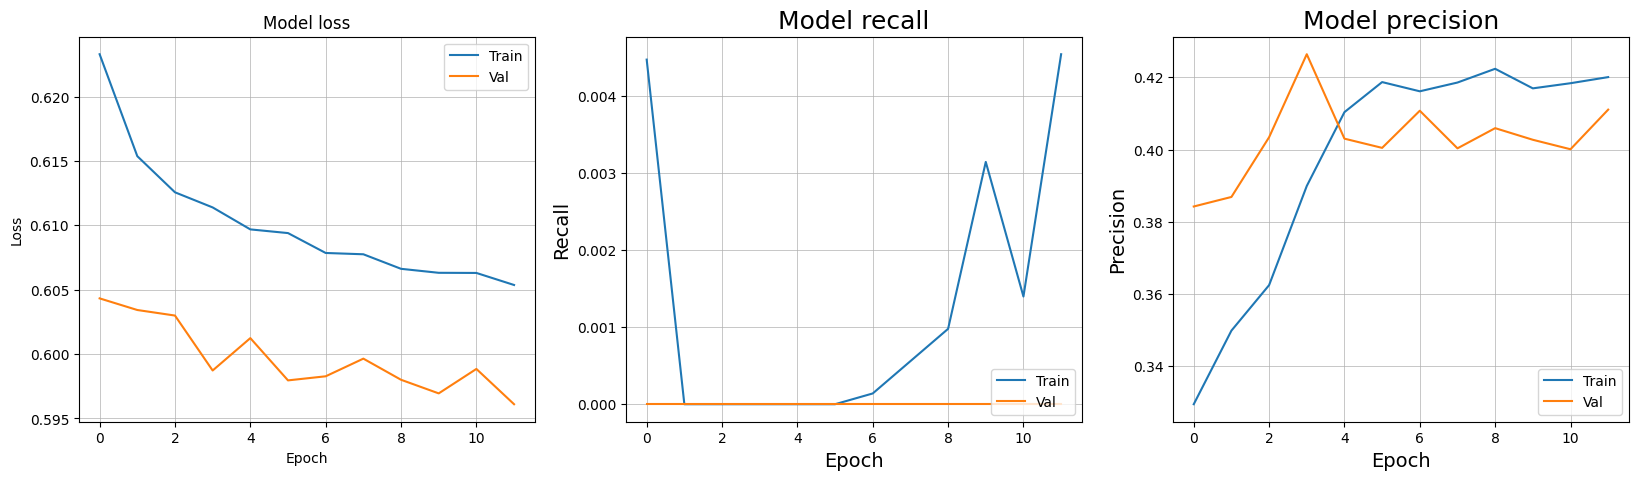

In [5]:
plot_loss_precision_recall_curve(history)

In [ ]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

In [8]:
y_pred_proba = model.predict(X_test)
threshold = 0.38 # 50% 
y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )
cm = confusion_matrix(y_test,y_pred_binary)
cm

455/455 [==============================] - 1s 1ms/step


array([[8464, 1630],
       [3367, 1092]])

Text(0.5, 25.722222222222214, 'Predicted label')

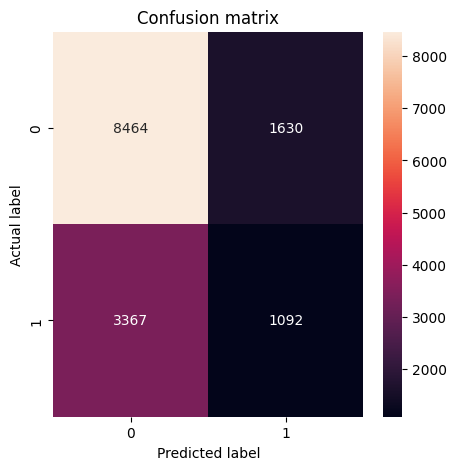

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [10]:
for i in range(35,55):
    threshold = i / 100
    y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )
    cm = confusion_matrix(y_test,y_pred_binary)
    print(f"Threshold: {i/100}")
    print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
    print(f"Accuracy: {round((cm[0,0] + cm[1,1]) / cm.sum() * 100,2)}")
    print(cm)
    print()

Threshold: 0.35
Precision: 38.7
Accuracy: 63.26
[[7686 2408]
 [2939 1520]]

Threshold: 0.36
Precision: 39.22
Accuracy: 64.08
[[7929 2165]
 [3062 1397]]

Threshold: 0.37
Precision: 39.89
Accuracy: 64.94
[[8183 1911]
 [3191 1268]]

Threshold: 0.38
Precision: 40.12
Accuracy: 65.66
[[8464 1630]
 [3367 1092]]

Threshold: 0.39
Precision: 41.13
Accuracy: 66.5
[[8713 1381]
 [3494  965]]

Threshold: 0.4
Precision: 42.4
Accuracy: 67.7
[[9177  917]
 [3784  675]]

Threshold: 0.41
Precision: 43.95
Accuracy: 68.56
[[9552  542]
 [4034  425]]

Threshold: 0.42
Precision: 42.92
Accuracy: 68.93
[[9844  250]
 [4271  188]]

Threshold: 0.43
Precision: 44.74
Accuracy: 69.25
[[10010    84]
 [ 4391    68]]

Threshold: 0.44
Precision: 48.15
Accuracy: 69.35
[[10080    14]
 [ 4446    13]]

Threshold: 0.45
Precision: nan
Accuracy: 69.36
[[10094     0]
 [ 4459     0]]

Threshold: 0.46
Precision: nan
Accuracy: 69.36
[[10094     0]
 [ 4459     0]]

Threshold: 0.47
Precision: nan
Accuracy: 69.36
[[10094     0]
 [ 4459

/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_78224/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_78224/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_78224/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_78224/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_78224/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82     10094
           1       0.00      0.00      0.00      4459

    accuracy                           0.69     14553
   macro avg       0.35      0.50      0.41     14553
weighted avg       0.48      0.69      0.57     14553



/Users/davidkatilius/.pyenv/versions/3.8.12/envs/Upvote_Model/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidkatilius/.pyenv/versions/3.8.12/envs/Upvote_Model/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidkatilius/.pyenv/versions/3.8.12/envs/Upvote_Model/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [ ]:
y_pred_proba = model.predict(X_test)
threshold = 0.38 # 50% 
y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )
cm = confusion_matrix(y_test,y_pred_binary)
cm
print(classification_report(y_test,y_pred_binary))